In [21]:
import numpy as np
import whisper_timestamped
import librosa
import python_speech_features as psf
import os
import json
import sys
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from scipy.special import softmax

sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Desktop/openpose/python/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')

from Signal_processing_utils import intensity_from_signal
from Evan_model import Aversion111Prior

In [2]:
%matplotlib widget

In [3]:
# inputs
input_folder = "/scratch/ondemand27/evanpan/data/shot_processed_dataset"
input_file_name = "_Emma_ Self Tape (2)_0"
temp_folder = "/scratch/ondemand27/evanpan/data/temp"
whisper_root = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset"
model_location = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/sentence_and_words"
speaker = 0

In [4]:
target_fps = 25

In [5]:
class SentenceBaseline_GazePredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_GazePredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)
        return x
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

In [6]:
def find_index(lst, t):
    for i in range(0, len(lst)):
        if t >= lst[i][0] and t <= lst[i][1]:
            return i, lst[i]
        elif t <= lst[i][0]:
            if i > 0:
                return -1, [lst[i-1][1], lst[i][0]]
            else:
                return -1, [-1, lst[i][0]] # assume the silence started before the current frame
        if i == len(lst) - 1:
            return -1, [lst[i][1], lst[i][1]+1]  # assume the silence ends after the current frame
def generate_word_structure_values(ts, word_list):
    if len(word_list) == 0:
        output_vector = np.zeros([ts.shape[0], 6])
        return output_vector
    # generate word embedding per word
    sentence_words = []
    word_intervals = []
    for i in range(0, len(word_list)):
        sentence_words.append(word_list[i]["text"])
        word_intervals.append([word_list[i]["start"], word_list[i]["end"]])
    output_vector = np.zeros([ts.shape[0], 6])
    # features
    # time since start of word (0 in silence, which means it will start at zero)
    # time till end of word (0 in silence as well,)
    # length of sentence 
    # time since start of silence (0 when speaking)
    # time till end of silence (0 when speaking)
    # length of silence
    for i in range(0, ts.shape[0]):
        t = ts[i]
        index, [start, end] = find_index(word_intervals, t)
        if index == -1:
            output_vector[i, 3] = t - start
            output_vector[i, 4] = t - end
            output_vector[i, 5] = start - end
        else:
            output_vector[i, 0] = t - start
            output_vector[i, 1] = t - end
            output_vector[i, 2] = start - end
    return output_vector
def generate_sentence_structure_values_real(ts, sentence_interval):
    if len(sentence_interval) == 0:
        output_vector = np.zeros([ts.shape[0], 6])
        return output_vector
    output_vector = np.zeros([ts.shape[0], 6])
    # features
    # time since start of word (0 in silence, which means it will start at zero)
    # time till end of word (0 in silence as well,)
    # length of sentence 
    # time since start of silence (0 when speaking)
    # time till end of silence (0 when speaking)
    # length of silence
    for i in range(0, ts.shape[0]):
        t = ts[i]
        index, [start, end] = find_index(sentence_interval, t)
        if index == -1:
            output_vector[i, 3] = t - start
            output_vector[i, 4] = t - end
            output_vector[i, 5] = start - end
        else:
            output_vector[i, 0] = t - start
            output_vector[i, 1] = t - end
            output_vector[i, 2] = start - end
    return output_vector
def parse_for_sentence_intervals(transcript, threshold=0.56):
    if len(transcript) == 0:
        return [], []
    sentence_intervals = [] # this is used to only store [[start, end]]
    sentence_words = [] # this is used to store [[all words of sentence]]
    current_sentence = [transcript[0]]
    for i in range(1, len(transcript)):
        word = transcript[i]["text"]
        start = transcript[i]["start"]
        end = transcript[i]["end"]
        if start - current_sentence[-1]["end"] >= threshold:
            sentence_words.append(current_sentence)
            sentence_intervals.append([current_sentence[0]["start"], current_sentence[-1]["end"]])
            current_sentence = [transcript[i]]
        else:
            current_sentence.append(transcript[i])
    return sentence_intervals, sentence_words



In [7]:
# get input paths
audio_path_self = os.path.join(*[input_folder, "audio", input_file_name+"_{}.wav".format(speaker)])
audio_path_other = os.path.join(*[input_folder, "audio", input_file_name+"_{}.wav".format(1-speaker)])
# output paths
word_output_path = os.path.join(*[temp_folder, input_file_name+"_transcript.json"])
processed_input_vector_self_path = os.path.join(*[temp_folder, input_file_name+"_input_feature_self.npy"])
processed_input_vector_other_path = os.path.join(*[temp_folder, input_file_name+"_input_feature_other.npy"])

# get the raw transcript prediction
model_word = whisper_timestamped.load_model("base.en", download_root=os.path.join(whisper_root, "whisper"))
raw_word_predictions_self = whisper_timestamped.transcribe(model_word, audio_path_self, beam_size=5, best_of=5, temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), vad=True)
raw_word_predictions_other = whisper_timestamped.transcribe(model_word, audio_path_other, beam_size=5, best_of=5, temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), vad=True)
# generate the json file containing word timing
word_alignment_self = []
for s in range(0,len(raw_word_predictions_self["segments"])):
    word_alignment_self = word_alignment_self + raw_word_predictions_self["segments"][s]["words"]
word_alignment_other = []
for s in range(0,len(raw_word_predictions_other["segments"])):
    word_alignment_other = word_alignment_self + raw_word_predictions_other["segments"][s]["words"]

trascript_json = {"self":word_alignment_self, "other":word_alignment_other}
json.dump(trascript_json, open(word_output_path, "w")) 

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

100%|██████████| 9193/9193 [00:05<00:00, 1800.29frames/s]


In [8]:
# get audio information
audio_self, sr = librosa.load(audio_path_self)
audio_other, sr = librosa.load(audio_path_other)
# padding these so we don't lose any frames (we are padding 
# half a window of the windowed functionss)
audio_self = np.pad(audio_self, ((int(0.02 * sr), int(0.02 * sr))))
audio_other = np.pad(audio_other, ((int(0.02 * sr), int(0.02 * sr))))
# generate the audio features for speaker 2
mfcc_a0 = psf.mfcc(audio_self, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=13)
logfbank_a0 = psf.logfbank(audio_self, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
ssc_feat_a0 = psf.logfbank(audio_self, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
full_feat_self = np.concatenate([mfcc_a0, logfbank_a0, ssc_feat_a0], axis=1)
# generate the audio features for speaker 1
mfcc_a1 = psf.mfcc(audio_other, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=13)
logfbank_a1 = psf.logfbank(audio_other, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
ssc_feat_a1 = psf.logfbank(audio_other, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
full_feat_other = np.concatenate([mfcc_a1, logfbank_a1, ssc_feat_a1], axis=1)

words = json.load(open(word_output_path, "r"))
self_text = words["self"]
other_text = words["other"]

ts_target = np.arange(0, full_feat_other.shape[0]) / target_fps
# get word vector
word_structure_feature_self = generate_word_structure_values(ts_target, self_text)
word_structure_feature_other = generate_word_structure_values(ts_target, other_text)
# get the sentence vector
interval_of_sentences_self, ___ = parse_for_sentence_intervals(self_text, 0.56)
interval_of_sentences_other, ___ = parse_for_sentence_intervals(other_text, 0.56)
sentence_structure_feature_self = generate_sentence_structure_values_real(ts_target, interval_of_sentences_self)
sentence_structure_feature_other = generate_sentence_structure_values_real(ts_target, interval_of_sentences_other)

output_feature_just_self = np.concatenate([full_feat_self, word_structure_feature_self, sentence_structure_feature_self], axis=1)
output_feature_just_other = np.concatenate([full_feat_other, word_structure_feature_other, sentence_structure_feature_other], axis=1)
output_feature_self = np.concatenate([output_feature_just_self, output_feature_just_other], axis=1)
output_feature_other = np.concatenate([output_feature_just_other, output_feature_just_self], axis=1)
np.save(processed_input_vector_self_path, output_feature_self)
np.save(processed_input_vector_other_path, output_feature_other)

# Load Input and Model

In [15]:
config = json.load(open(os.path.join(*[model_location, "config.json"]), "r"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_weights_path = os.path.join(*[model_location, "best.pt"])
pretrained_dict = torch.load(model_weights_path, map_location=device)
model = SentenceBaseline_GazePredictionModel(config)
model.load_weights(pretrained_dict)
model.to(device)
X = torch.from_numpy(np.expand_dims(np.load(processed_input_vector_self_path), axis=0)).to(device)

out = model(X)[0].cpu().detach().numpy()
out = softmax(out, axis=1)

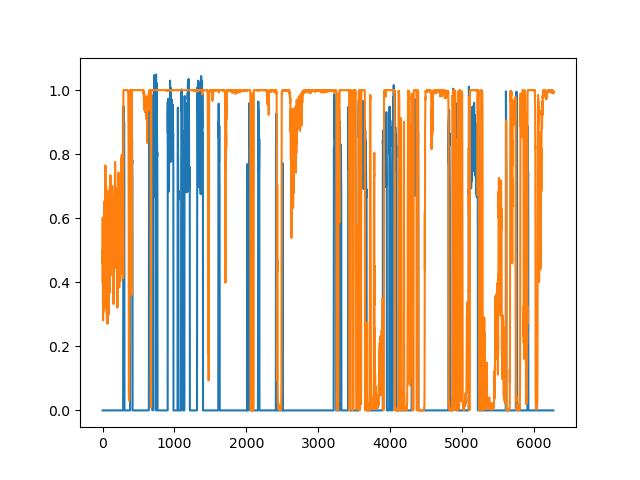

In [16]:
audio, sr = librosa.load(audio_path_self)
intensity = intensity_from_signal(audio, int(1/25.0 * sr))
plt.cla()
plt.plot(intensity/80)
plt.plot(out[:, 0])
plt.show()